# Ficha de Trabalho 1

##  Exercício 1

### a) Modelo dinâmico do processo em modo batch, para G, S, E, X e V.
As equações diferenciais ordinárias para o sistema em modo *batch* são:

$$\frac{d[X]}{dt} = (\mu_1 + \mu_2 + \mu_3) * [X]$$

$$\frac{d[S]}{dt} = -k_2 \ \mu_2 \ [X] $$

$$\frac{d[G]}{dt} = -k_1 \ \mu_1 \ [X]$$

$$\frac{d[E]}{dt} = (k_3 \ \mu_2 -k_4 \ \mu_3) * [X]$$

$$\frac{d[V]}{dt} = 0$$

### b) Modelo dinâmico do processo em modo fed-batch, para G, S, E, X e V.
As equações diferenciais ordinárias para o sistema em modo *fed-batch* são:

$$\frac{d[X]}{dt} = (\mu_1 + \mu_2 + \mu_3) * [X] -\frac{Fe}{V}[X]$$

$$\frac{d[S]}{dt} = -k_2 \ \mu_3 \ [X] +\frac{Fe}{V}[S_e] -\frac{Fe}{V}[S]$$

$$\frac{d[G]}{dt} = -k_1 \ \mu_1 \ [X] -\frac{Fe}{V}[G]$$

$$\frac{d[E]}{dt} = (k_3 \ \mu_2 -k_4 \ \mu_3) * [X] -\frac{Fe}{V}[E]$$

$$\frac{d[V]}{dt} = Fe$$

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dst
from scipy.integrate import ode
from scipy.optimize import basinhopping
from scipy.optimize import fsolve
from sympy import symbols, Symbol
import numdifftools as ndt

## Exercício 2

In [11]:
# Model bl21
def bl21(t, Y, k, miu_max, ks, fb=(), cs=()):
	"""
	This will be the model for the strain BL21

	:param t: time; This argument should not be altered
	:param Y: initial conditions; array-like data structure (list, tuple, numpy array)
	:param K_params: Estimated K parameters; array-like data structure (list, tuple, numpy array)
	:param miu_max: Estimated K parameters; array-like data structure (list, tuple, numpy array)
	:param ks:
	:param fb: Optional set of  parameters that set the model into Fed-Batch mode if provided; array-like data structure (list, tuple, numpy array)
	:param cs: Optional set of  parameters that set the model into Chemostat mode if provided; array-like data structure (list, tuple, numpy array)
	:return: K * phi - (D (F/V) * variables) + zeros; note that numpy.dot() is the standard for matrices multiplication

	"""
	# Calculate per reaction miu
	m = [Y[1], Y[1], Y[2]]
	miu = [miu_max[i]*(m[i]/(ks[i]+m[i])) for i in range(3)]

	# batch (basic) logic
	def batch():
		dXdt = miu[0]*Y[0] + miu[1]*Y[0] + miu[2]*Y[0]
		dSdt = (-k[0])*miu[0]*Y[0] - k[1]*miu[1]*Y[0]
		dAdt = k[2]*miu[1]*Y[0] - k[3]*miu[2]*Y[0]
		dPdt = k[10]*miu[0]*Y[0]
		dVdt = 0
		return [dXdt, dSdt, dAdt, dPdt, dVdt]

  # decorator invocation for extra modes
	def fedbatch(func):
		D = fb[0]/Y[4] # Fe/V
		dilution = [-D*Y[0], D*fb[1] -D*Y[1], -D*Y[2], -D*Y[3], fb[0]]
		return np.add(func,dilution)

	def quimiostato(func):
		D = cs[0]/Y[4] # Fin/V
		dilution = [-D*Y[0], D*cs[1]-D*Y[1], -D*Y[2], -D*Y[3], 0]
		return np.add(func,dilution)

	if cs:
		return quimiostato(batch())
	elif fb:
		return fedbatch(batch())
	else:
		return batch()

### a) Equações o modelo dinâmico do processo para X, S, A, P e V em modo descontínuo (batch).
As equações diferenciais ordinárias para o sistema em modo *batch* são:

$$\frac{d[X]}{dt} = (\mu_1 + \mu_2 + \mu_3) * [X]$$

$$\frac{d[S]}{dt} = - (k_1 \ \mu_1 + k_2 \ \mu_2) \ [X]$$

$$\frac{d[A]}{dt} = (k_3 \ \mu_2 - k_4 \ \mu_3 ) \ [X]$$

$$\frac{d[P]}{dt} = k_{11} \ \mu_1 \ [X]$$

$$\frac{d[V]}{dt} = 0$$

### b) Implementação do modelo em a) e a sua integração para um período de 3 horas.

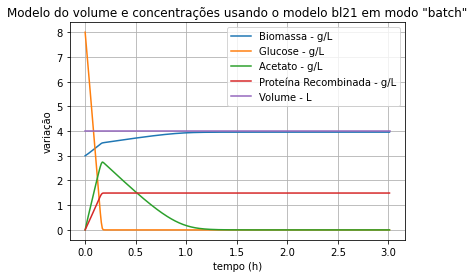

In [ ]:
# Initial conditions
y0 = [3, 8, 0, 0, 4]

# Parameters (Include all parameters required and make sure the function bl21 can unpack them all)
params = [3.164, 25.22, 10.90, 6.382, 1.074, 11.89, 6.098, 1.283, 19.01, 6.576, 10.0]
miu_max = [0.3, 0.6, 0.2]
ks = [0.2, 0.2, 0.5]

# Initial time
t0 = 0

# ode
'''
consider scipy.integrate.ode method, with the integrator lsoda and method bdf
you should apply the initial values and parameters
'''

r = ode(bl21).set_integrator('lsoda', method='bdf')
r.set_initial_value(y0, t0).set_f_params(params, miu_max, ks)

# Final time and step
t1 = 3
dt = 0.01

#Consider creating some storing variables (T and Y)
T, Y = [], []

# Solve ode for the time step
'''
see scipy docs on how to resolve the ode for the time steps
append the results to the storing variables
'''

while r.successful() and r.t < t1:
	T.append(r.t+dt), Y.append(r.integrate(r.t+dt))

# Plotting
T = np.array([0]+T)
Y = np.array([y0]+Y)
labels = ['Biomassa - g/L', 'Glucose - g/L', 'Acetato - g/L', 'Proteína Recombinada - g/L', 'Volume - L']

# Consider using matplotlib for plotting.
fig, ax = plt.subplots()
ax.plot(T, Y)
ax.legend(labels)
ax.set(xlabel='tempo (h)', ylabel='variação',title='Modelo do volume e concentrações usando o modelo bl21 em modo "batch"')
ax.grid()
fig.savefig("bl21_b_3h.png", dpi=300)
plt.show()

No decorrer do período de duas horas, o volume manteve-se constante, isto é expectável dado que não existe a adição ou remoção de volumes, como pode acontecer em outros sistemas o *fed-batch*.
O sistema começa também com glucose e biomassa. A primeira é responsável pela produção de acetato, proteína recombinante e biomassa.
Quando esta é completamente consumida, deixa de haver produção de acetato e proteína recombinante.
O acetato, neste sistema faz parte também da produção de biomassa, sendo esta a razão pelo o qual,
aquele que foi produzido, acaba por ser consumido, e so quando este é esgotado, observamos uma estabilização da quantidade de biomassa presente no sistema.

### c) Equações o modelo dinâmico do processo para X, S, A, P e V em modo semi-contínuo (fed-batch).

$$\frac{d[X]}{dt} = (\mu_1 + \mu_2 + \mu_3) * [X] - \frac{Fe}{V}[X]$$

$$\frac{d[S]}{dt} = - (k_1 \ \mu_1 + k_2 \ \mu_2) \ [X] + \frac{Fe}{V}[S_e] - \frac{Fe}{V}[S]$$

$$\frac{d[A]}{dt} = (k_3 \ \mu_2 - k_4 \ \mu_3 ) \ [X] - \frac{Fe}{V}[A]$$

$$\frac{d[P]}{dt} = k_{11} \ \mu_1 \ [X] - \frac{Fe}{V}[P]$$

$$\frac{d[V]}{dt} = Fe$$

### d) Implementação do modelo em c) e a sua integração para um período de 25 horas.

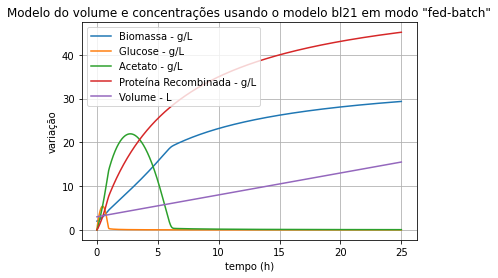

In [ ]:
# Initial conditions
y0 = [2, 0, 0, 0, 3]

# Parameters (Include all parameters required and make sure the function bl21 can unpack them all)
params = [3.164, 25.22, 10.90, 6.382, 1.074, 11.89, 6.098, 1.283, 19.01, 6.576, 10.0]
miu_max = [0.3, 0.6, 0.2]
ks = [0.2, 0.2, 0.5]
fb_params = [0.5, 300]

# Initial time
t0 = 0

# ode
'''
consider scipy.integrate.ode method, with the integrator lsoda and method bdf
you should apply the initial values and parameters
'''

r = ode(bl21).set_integrator('lsoda', method='bdf')
r.set_initial_value(y0, t0).set_f_params(params, miu_max, ks, fb_params)

# Final time and step
t1 = 25
dt = 0.01

#Consider creating some storing variables (T and Y)
T, Y = [], []

# Solve ode for the time step
'''
see scipy docs on how to resolve the ode for the time steps
append the results to the storing variables
'''
while r.successful() and r.t < t1:
	T.append(r.t+dt), Y.append(r.integrate(r.t+dt))

# Plotting
T = np.array([0]+T)
Y = np.array([y0]+Y)
labels = ['Biomassa - g/L', 'Glucose - g/L', 'Acetato - g/L', 'Proteína Recombinada - g/L', 'Volume - L']

# Consider using matplotlib for plotting.
fig, ax = plt.subplots()
ax.plot(T, Y)
ax.legend(labels)
ax.set(xlabel='tempo (h)', ylabel='variação',title='Modelo do volume e concentrações usando o modelo bl21 em modo "fed-batch"')
ax.grid()
fig.savefig("bl21_fb_25h.png", dpi=300)
plt.show()

Neste modelo ao contrário de em *batch* existe a variação de volume, esta deve-se à existência um fluxo de entrada de substrato, que neste caso é constante, levando a um aumento do volume linear, diluindo todos os outros elementos do sistema. Como o fluxo de entrada inclui uma certa quantidade de substrato, nem todos os elementos estão sujeitos ao mesmo efeito de diluição. A existência de substrato


## e)

In [12]:
# Criar modelo para a bactéria JM109
def jm109(t, Y, params):
  """

  This will be the model for the strain JM109 which is similar to the BL21, but it should have slight modifications

  :param t: time; This argument should not be altered
  :param Y: initial conditions; array-like data structure (list, tuple, numpy array)
  :param params: parameters; array-like data structure (list, tuple, numpy array) - NOTE THAT THESE ARGUMENT MUST
  CONTAIN ONLY AND ONLY THOSE PARAMETERS TO BE ESTIMATED. The remain parameters should be hardcoded within the
  function
  :return: K * phi - (D * variables) + zeros; note that numpy.dot() is the standard for matrices multiplication

  """
	# operations mode

  k = [params[0], 25.22, 10.90, 6.382, 1.074, 11.89, 6.098, 1.283, 19.01, 6.576, 10.0]
  miu_max = [params[1], 0.6, 0.2]
  ks = [params[2], 0.2, 0.5]
  fb = [0.5, 300]

  return bl21(t, Y, k, miu_max, ks, fb)


In [7]:
# Criar função para estimação dos parâmetros
def estimate(params):
  """
  This will be our estimate function that works out as the calculation of the difference between the experimental
  and predicted values and can be used as the objective function

  :param params: parameters; array-like data structure (list, tuple, numpy array) for the ode
  :return: the error between measured and predicted data, i.e. difS + difX + difA + difV
  """

  # Consider using global to access and change global variables outside of this function
  # Otherwise, model, time, initial conditions and experimental data can be hardcoded here within the function
  # Nevertheless, use always the global Y (array to store the results) to re-write this variable with new results
  global model
  global t
  global dados_exp
  global y0
  global Y

  # timespan (initial, final, step)
  t0 = t[0]

  # Initial conditions
  y0=y0

  # ode
  # consider scipy.integrate.ode method, with the integrator lsoda and method bdf
  # you should apply the initial values and parameters

  # Final time and step
  t1 = t[1]
  dt = t[2]

  # Using the global storing variable Y

  # Solve ode for the time step
  # see scipy docs on how to resolve the ode for the time steps
  # append the results to the Y storing variable
  r = ode(model).set_integrator('lsoda', method='bdf')
  r.set_initial_value(y0, t0).set_f_params(params)
  
  a = 0
  while r.successful() and r.t < t1:
    a += 1
    Y[a,:]=r.integrate(r.t+dt)

  # Remove the set o P concentrations values calculated from the model, as we have no experimental data to confirm it
  
  y_comparable = np.delete(Y,3,1)
  
  # Consider the metrics to calculate the error between experimental and predicted data
  return sum([dst.sqeuclidean(dados_exp.iloc[:,n+1], y_comparable[:,n]) for n in range(4)])

In [8]:
# Bounds
# Consider using the following class for setting the Simulated Annealing bounds
class Bounds(object):

  def __init__(self, LB=None, UB=None):
    if LB is None:
      LB = [0, 0, 0]
    if UB is None:
      UB = [4, 4, 4]

    self.lower_bound = np.array(LB)
    self.upper_bound = np.array(UB)

  def __call__(self, **kwargs):
    x = kwargs["x_new"]
    tmax = bool(np.all(x <= self.upper_bound))
    tmin = bool(np.all(x >= self.lower_bound))

    return tmax and tmin

In [13]:
model = jm109
t = (0, 20, 0.5)
dados_exp = pd.read_csv("dados_exp.csv")
y0 = [1, 0, 0, 0, 3]
Y = np.zeros((41,5))
Y[0,:] = y0

#Bounds
LB = [0, 0, 0]
UB = [4, 4, 4]
bounds = Bounds(LB, UB)

# initial guess, that is the initial values for the parameters to be estimated. It can be those available in the pdf
x0 = [3.164, 0.3, 0.2]

# Simulated Annealing
# consider scipy.optimize.basinhopping method, with the method BFGS, niter 200, seed 1 and the respective bounds.
# To perform some testing consider lowering the number of iterations to 10, as SA can take a while

minimizer_kwargs = {"method": "BFGS"}
ret = basinhopping(estimate, x0, minimizer_kwargs=minimizer_kwargs,niter=200, accept_test=bounds, seed=1)

/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  self.messages.get(istate, unexpected_istate_msg)))
/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  self.messages.get(istate, unexpected_istate_msg)))
/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  self.messages.get(istate, unexpected_istate_msg)))
/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  self.messages.get(istate, unexpected_istate_msg)))
/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  self.messages.get(istate, unexpected_istate_msg)))
/usr/

In [15]:
print(f"global minimum: k1 = {ret.x[0]}, miu_max1 = {ret.x[1]}, ks1 = {ret.x[2]}")

global minimum: k1 = 3.9964711690374237, miu_max1 = 0.23050863427339316, ks1 = 3.3118980454252465


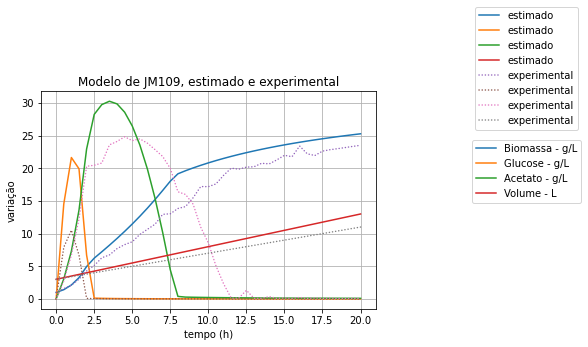

In [57]:
# Initial conditions
y0 = [1, 0, 0, 0, 3]

# Parameters (Include all parameters required and make sure the function bl21 can unpack them all)
k1, umax1, ks1 = 3.9964711690374237, 0.23050863427339316, 3.3118980454252465
params = [k1, umax1, ks1]

# Initial time
t0 = 0

# ode
'''
consider scipy.integrate.ode method, with the integrator lsoda and method bdf
you should apply the initial values and parameters
'''

r = ode(jm109).set_integrator('lsoda', method='bdf')
r.set_initial_value(y0, t0).set_f_params(params)

# Final time and step
t1 = 20
dt = 0.5

#Consider creating some storing variables (T and Y)
T, Y = [], []

# Solve ode for the time step
'''
see scipy docs on how to resolve the ode for the time steps
append the results to the storing variables
'''
while r.successful() and r.t < t1:
	T.append(r.t+dt), Y.append(r.integrate(r.t+dt))

# Plotting
T = np.array([0]+T)
Y = np.array([y0]+Y)
labels = ['Biomassa - g/L', 'Glucose - g/L', 'Acetato - g/L', 'Volume - L']
colors = ['b', 'r', 'g', 'c']

# remove PR
y = np.delete(Y,3,1)

# Consider using matplotlib for plotting.
fig, ax = plt.subplots()
ax.plot(T, y, label ="estimado")
ax.plot(T, dados_exp.iloc[:,1:5],linestyle = (0,(0.1,2)), dash_capstyle = 'round', label ="experimental")
first_legend = ax.legend(labels, loc='upper center', bbox_to_anchor=(1.45, 0.8))
ax.legend(loc='lower center', bbox_to_anchor=(1.45, 0.8),)
plt.gca().add_artist(first_legend)
ax.set(xlabel='tempo (h)', ylabel='variação',title='Modelo de JM109, estimado e experimental')
ax.grid()
fig.savefig("jm109_comp.png", dpi=300)
plt.show()

## f) Sensibilidades ao longo do tempo das variáveis X e S aos parâmetros k1, μmax1 e Ks1.

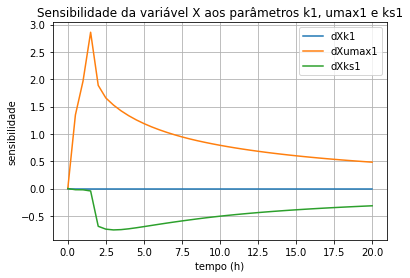

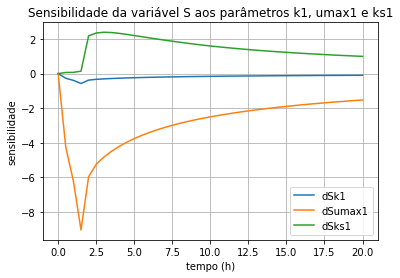

In [ ]:
y0 = [ 1, 0, 0, 0, 3] # PR Has been removed as it is not useful, it has not been provided in the experimentally produced dataset

Fe, Se = 0.5, 300

# params = params
k1, umax1, ks1 = 41.12039287713514, 0.126692533253695, 0.2
params = [k1, umax1, ks1]

# k parameters except k1
k2 = 25.22
k3 = 10.90
k4 = 6.382
k11 = 10.0

# umax's except umax1
umax2 = 0.6
umax3 = 0.2

# Ks's except ks1
ks2 = 0.2
ks3 = 0.5

# Consider using sympy.symbols to create algebric variables to be used on the derivatives (X, S, k1, ks1, ...)
(X, S, A, V, k1, ks1, umax1) = symbols('X, S, A, V, k1, ks1, umax1')

# mu's
miu1 = umax1*S/(S+ks1)
miu2 = umax2*S/(S+ks2)
miu3 = umax3*A/(A+ks3)

# ordinary differential equations DX and DS
dXdt = miu1*X + miu2*X + miu3*X - (Fe/V)*X
dSdt = (-k1)*miu1*X - k2*miu2*X - (Fe/V)*S + (Fe/V)*Se

# perform the derivatives in order at k1, umax1 and ks1. Consider using sympy's method: diff
# dXk1 = sp.diff(dxdt, k1)
from sympy import diff

dXk1 = diff(dXdt, k1)
dXumax1 = diff(dXdt, umax1)
dXks1 = diff(dXdt, ks1)

dSk1 = diff(dSdt, k1)
dSumax1 = diff(dSdt, umax1)
dSks1 = diff(dSdt, ks1)

# transform the derivates expression into lambda functions to calculate the calculate the sensitivity values of each
# derivate form. Consider using sympy lambdify where the args of the lambda function are the algebric variables in the
# derivate expression. Choose the numpy module for the calculations
from sympy.utilities.lambdify import lambdify
dXk1 = lambdify((X,S,k1,ks1, umax1), dXk1, "numpy")
dXumax1 = lambdify((X,S,k1,ks1, umax1), dXumax1, "numpy")
dXks1 = lambdify((X,S,k1,ks1, umax1), dXks1, "numpy")

dSk1 = lambdify((X,S,k1,ks1, umax1), dSk1, "numpy")
dSumax1 = lambdify((X,S,k1,ks1, umax1), dSumax1, "numpy")
dSks1 = lambdify((X,S,k1,ks1, umax1), dSks1, "numpy")


# t = timespan
# Final time and step
t0 = 0
t1 = 20
dt = 0.5

# ode
# consider scipy.integrate.ode method, with the integrator lsoda and method bdf
# you should apply the initial values and parameters

r = ode(jm109).set_integrator('lsoda', method='bdf')
r.set_initial_value(y0, t0).set_f_params(params)


# Using the global storing variable Y
T = [0]
Y = np.zeros((41,5))
Y[0,:] = y0

# Solve ode for the time step
# see scipy docs on how to resolve the ode for the time steps
# append the results to the Y storing variable

a = 0
while r.successful() and r.t < t1:
    T.append(r.t+dt) #r.t
    a += 1
    Y[a,:]=r.integrate(r.t+dt)

# create the dx and ds arrays executing the lambda function for the X, S, k1, umax1, ks1 values
k1, umax1, ks1= 3.164, 0.3, 0.2

dX = np.zeros((41,3))
dX[:,0] = dXk1(Y[:,0],Y[:,1],k1, umax1, ks1)
dX[:,1] = dXumax1(Y[:,0],Y[:,1],k1, umax1, ks1)
dX[:,2] = dXks1(Y[:,0],Y[:,1],k1, umax1, ks1)

dS = np.zeros((41,3))
dS[:,0] = dSk1(Y[:,0],Y[:,1],k1, umax1, ks1)
dS[:,1] = dSumax1(Y[:,0],Y[:,1],k1, umax1, ks1)
dS[:,2] = dSks1(Y[:,0],Y[:,1],k1, umax1, ks1)


# Consider using matplotlib for plotting.
labels = ['dXk1', 'dXumax1', 'dXks1']
fig, ax = plt.subplots()
ax.plot(T, dX)
ax.legend(labels)
ax.set(xlabel='tempo (h)', ylabel='sensibilidade',title='Sensibilidade da variável X aos parâmetros k1, umax1 e ks1')
ax.grid()
fig.savefig("jm109_x_sense.png", dpi=300)
plt.show()

labels = ['dSk1', 'dSumax1', 'dSks1']
fig, ax = plt.subplots()
ax.plot(T, dS)
ax.legend(labels)
ax.set(xlabel='tempo (h)', ylabel='sensibilidade',title='Sensibilidade da variável S aos parâmetros k1, umax1 e ks1')
ax.grid()
fig.savefig("jm109_s_sense.png", dpi=300)
plt.show()

## g)

Com base nos resultados anteriores podemos confirmar que tanto na derivada de X e S em função de k1, esta é proxima ou igual de 0 no periodo estudado. Como tal podemos remover este do modelo sem causar alterações consideraveis dos valores finais.

$$\frac{d[X]}{dt} = (\mu_1 + \mu_2 + \mu_3) * [X] - \frac{Fe}{V}[X]$$

$$\frac{d[S]}{dt} = - (mu_1 + k_2 \ \mu_2) \ [X] + \frac{Fe}{V}[S_e] - \frac{Fe}{V}[S]$$

$$\frac{d[A]}{dt} = (k_3 \ \mu_2 - k_4 \ \mu_3 ) \ [X] - \frac{Fe}{V}[A]$$

$$\frac{d[P]}{dt} = k_{11} \ \mu_1 \ [X] - \frac{Fe}{V}[P]$$

$$\frac{d[V]}{dt} = Fe$$

O modelo, porém é mais sensível aos outros valores. Sendo que estes têm comportamentos contrários para a variável X e S. Isto faz sentido, uma vez que o que leva a um aumento de consumo do substrato, é responsável também pelo o aumento do produto.

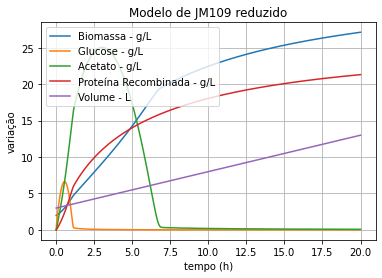

In [24]:
# Initial conditions
y0 = [2, 0, 0, 0, 3]

# Parameters (Include all parameters required and make sure the function bl21 can unpack them all)
k1, umax1, ks1 = 1, 0.2, 0.3
params = [k1, umax1, ks1]

# Initial time
t0 = 0

# ode
'''
consider scipy.integrate.ode method, with the integrator lsoda and method bdf
you should apply the initial values and parameters
'''

r = ode(jm109).set_integrator('lsoda', method='bdf')
r.set_initial_value(y0, t0).set_f_params(params)

# Final time and step
t1 = 20
dt = 0.01

#Consider creating some storing variables (T and Y)
T, Y = [], []

# Solve ode for the time step
'''
see scipy docs on how to resolve the ode for the time steps
append the results to the storing variables
'''
while r.successful() and r.t < t1:
	T.append(r.t+dt), Y.append(r.integrate(r.t+dt))

# Plotting
T = np.array([0]+T)
Y = np.array([y0]+Y)
labels = ['Biomassa - g/L', 'Glucose - g/L', 'Acetato - g/L', 'Proteína Recombinada - g/L', 'Volume - L']

# Consider using matplotlib for plotting.
fig, ax = plt.subplots()
ax.plot(T, Y)
ax.legend(labels)
ax.set(xlabel='tempo (h)', ylabel='variação',title='Modelo de JM109 reduzido')
ax.grid()
fig.savefig("jm109_red.png", dpi=300)
plt.show()

## h)

In [ ]:
def cs_bl21_model(y0):
	# Condicoes iniciais
	X = y0[0]
	S = y0[1]
	A = y0[2]
	V = y0[3]

	# Parametros
	S0 = 300
	Fe = 0.5
	Fs = 0.5
	K1,K2,K3,K4,Ks1,Ks2,Ks3 = [3.164, 25.22, 10.90, 6.382, 0.2, 0.2, 0.5]
	umax1,umax2,umax3 = [0.3, 0.6, 0.2]

	#Equacoes
	u1=umax1*(S/(Ks1+S))
	u2=umax2*(S/(Ks2+S))
	u3=umax3*(A/(Ks3+A))
	return np.array([u1*X+u2*X+u3*X, (-K1)*u1*X - K2*u2*X ,K3*u2*X - K4*u3*X, Fe-Fs])

# Solve for no biomass
y0 = np.array([0,1,1,6])
a = fsolve(cs_bl21_model, y0)
print(a)

y0 = np.array([1,1,1,6])
b = fsolve(cs_bl21_model, y0)
print(b)

[0. 1. 1. 6.]
[2.98198231e-18 2.54742877e+00 1.83000135e+00 6.00000000e+00]


In [ ]:
jacob = ndt.Jacobian(cs_bl21_model)
print("Sem Biomassa")
print(jacob(a))
print(np.trace(jacob(a)))
print(np.linalg.det(jacob(a)))

print("Existe Biomassa")
print(jacob(b))
print(np.trace(jacob(b)))
print(np.linalg.det(jacob(b)))


Sem Biomassa
[[  0.88333333   0.           0.           0.        ]
 [-13.401        0.           0.           0.        ]
 [  4.59906667   0.           0.           0.        ]
 [  0.           0.           0.           0.        ]]
0.8833333333333333
0.0
Existe Biomassa
[[ 9.91565768e-01  7.11090186e-20  5.49278649e-20  0.00000000e+00]
 [-1.49105636e+01 -1.27057594e-18  0.00000000e+00  0.00000000e+00]
 [ 5.06142392e+00  5.16725535e-19 -3.50549634e-19  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0.9915657677484429
0.0
